In [90]:
import tkinter as tk
from tkinter import filedialog
import numpy as np  
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import cv2 
import pandas as pd
from skimage.metrics import structural_similarity as ssim

In [2]:
def select_images():
    root = tk.Tk()
    root.wm_attributes('-topmost', 1)
    root.withdraw()

    file_paths = filedialog.askopenfilenames(title="Select Image Files", filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.gif")])

    images = []
    if file_paths:
        for file_path in file_paths:
            image = cv2.imread(file_path,0)
            image = cv2.resize(image, (512, 512))
            images.append(image)
    return images

In [3]:
def create_mosaic(images):
    def img_norm(img):
        return img/img.max()
    
    if len(images) == 1:
        return images[0]
    elif len(images) <= 4:
        block1 = np.block([[img_norm(images[0]), img_norm(images[2])], [img_norm(images[1]), img_norm(images[3])]])
        return block1
    else:
        # Recursively apply this function on LL
        return np.block([[img_norm(create_mosaic(images[4:])),img_norm(images[2])], [img_norm(images[1]), img_norm(images[3])]])

In [4]:
def plot_MRDCT(coeffs,level):
    labels = ['LL','HL','LH','HH']
    # Display the coefficients for each level
    if level ==1: figsize=(12, 12)
    else: figsize=(4*4, level*4)
    fig, axes = plt.subplots(level, 4, figsize=figsize)
    for i, coeff in enumerate(coeffs):
        row, col = i // 4, i % 4
        if level !=1:
            
            axes[row, col].imshow(coeff, cmap='gray')
            axes[row, col].set_title('IDCT '+f'${labels[i%4]}_{i//4+1}$')
        else:
            axes[col].imshow(coeff, cmap='gray')
            axes[col].set_title('IDCT '+f'${labels[i%4]}_{i//4+1}$')
    plt.tight_layout()
    plt.show()  

In [5]:
def MRDCT(image, level=1,disp=False):
    """
    Perform Multi Resolution DCT on an image
    
    Parameters:
    image: ndarray
        The input image as a numpy array
    level: int, optional (default=1)
        The number of decomposition levels to perform
        
    Returns:
    coeffs: list
        A list of numpy arrays containing the IDCT coefficients [LL,{LH,HL,HH}]
    """
    coeffs = []
    
    for i in range(level):
        # Perform DCT on columns
        dct_cols = dct(image, axis=0,type=2, norm='ortho')
        
        # Split into upper and lower halves along rows
        split_row = dct_cols.shape[0] // 2
        upper_half = dct_cols[:split_row, :]
        lower_half = dct_cols[split_row:, :]
        
        # Perform IDCT on each half along columns
        idct_upper = idct(upper_half, axis=0,type=2, norm='ortho')
        idct_lower = idct(lower_half, axis=0,type=2, norm='ortho')
        
        # Combine the halves and perform DCT on rows
        dct_rows_upper = dct(idct_upper, axis=1,type=2, norm='ortho')
        dct_rows_lower = dct(idct_lower, axis=1,type=2, norm='ortho')

        # Split into LL, LH, HL, HH coefficients
        split_col_u = dct_rows_upper.shape[1] // 2
        split_col_l = dct_rows_lower.shape[1] // 2
        LL_f = dct_rows_upper[:, :split_col_u]
        LH_f = dct_rows_upper[:, split_col_u:]
        HL_f = dct_rows_lower[:, :split_col_l]
        HH_f = dct_rows_lower[:, split_col_l:]
        LL = idct(LL_f, axis=1,type=2, norm='ortho')
        LH = idct(LH_f, axis=1,type=2, norm='ortho')
        HL = idct(HL_f, axis=1,type=2, norm='ortho')
        HH = idct(HH_f, axis=1,type=2, norm='ortho')
        
        # Append the coefficients to the list
        coeffs.append(LL)
        coeffs.append(LH)
        coeffs.append(HL)
        coeffs.append(HH)
        # Update the image for the next level
        image = LL.copy()

    if disp :       
        cv2.imshow('IDCT',create_mosaic(coeffs))
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return coeffs 

In [6]:
def IMRDCT(coeff): 
    batches = []
    for i in range(0, len(coeff), 4):
        batches.append(coeff[i:i+4])
    batches =batches[::-1]
    def block_LL(LL_I,LH_I,HL_I,HH_I):
        LL = dct(LL_I, axis=1,type=2, norm='ortho')
        LH = dct(LH_I, axis=1,type=2, norm='ortho')
        HL = dct(HL_I, axis=1,type=2, norm='ortho')
        HH = dct(HH_I, axis=1,type=2, norm='ortho')
        block_up_col = idct(np.block([LL ,LH]),axis=1,type=2, norm='ortho')
        block_low_col = idct(np.block([HL ,HH]), axis=1,type=2, norm='ortho')
        block_up_row = dct(block_up_col,axis=0,type=2, norm='ortho')
        block_low_col = dct(block_low_col, axis=0,type=2, norm='ortho')
        block1=idct(np.block([[block_up_row],[block_low_col]]), axis=0,type=2, norm='ortho')
        return block1
    
    LL = []
    if len(batches)==1:
        return block_LL(batches[0][0],batches[0][1],batches[0][2],batches[0][3])
    else: 
        for i,val in enumerate(batches):
            if i==0:
               LL.append(block_LL((val[0]),val[1],val[2],val[3]))   
            else:   
               LL.append(block_LL(LL[i-1],val[1],val[2],val[3]))   
        return LL[-1]

In [7]:
def fusion(img_1,img_2,level=2,details='min',approx ='mean'):
    def get_max_magnitude_pixel(A, B):
        # Ensure images are of the same shape
        assert A.shape == B.shape
        
        # Calculate the magnitude of each pixel in the images
        mag1 = np.abs(A)
        mag2 = np.abs(B)
        
        # Determine which image has the higher magnitude pixel for each location
        higher_mag_mask = mag1 > mag2
        
        # Combine the masks with the original images to obtain the maximum magnitude pixels
        max_pixels = np.zeros_like(A)
        max_pixels[higher_mag_mask] = A[higher_mag_mask]
        max_pixels[~higher_mag_mask] = B[~higher_mag_mask]
        
        # Return the maximum magnitude pixels
        return max_pixels

    def get_min_magnitude_pixel(A, B):
        # Ensure images are of the same shape
        assert A.shape == B.shape
        
        # Calculate the magnitude of each pixel in the images
        mag1 = np.abs(A)
        mag2 = np.abs(B)
        
        # Determine which image has the smaller magnitude pixel for each location
        lower_mag_mask = mag1 < mag2
        
        # Combine the masks with the original images to obtain the minimum magnitude pixels
        min_pixels = np.zeros_like(A)
        min_pixels[lower_mag_mask] = A[lower_mag_mask]
        min_pixels[~lower_mag_mask] = B[~lower_mag_mask]
        
        # Return the minimum magnitude pixels
        return min_pixels

    coeff =[]
    coeffs_1 = MRDCT(img_1,level,disp=False)
    coeffs_2 = MRDCT(img_2,level,disp=False)
    for i, val in enumerate(coeffs_1):
        if i % 4 == 0 :
            if approx =='min':
                coeff.append(get_min_magnitude_pixel(coeffs_2[i],coeffs_1[i]))
            elif approx == 'max':
                coeff.append(get_max_magnitude_pixel(coeffs_2[i],coeffs_1[i]))      
            else:
                mean_coeff = (coeffs_1[i]+coeffs_2[i])/2
                coeff.append(mean_coeff)
        else:
            # Compare the magnitudes of the matrices using the specified metric
            if details == 'min':
                coeff.append(get_min_magnitude_pixel(np.abs(coeffs_2[i]),np.abs(coeffs_1[i])))
            elif details == 'max':
                coeff.append(get_max_magnitude_pixel(coeffs_2[i],coeffs_1[i]))
            elif details == 'mean':
                #coeff.append(np.mean(np.array([coeffs_1[i],coeffs_2[i]]),axis=0))
                mean_coeff = (coeffs_1[i]+coeffs_2[i])/2
                coeff.append(mean_coeff)
            else:
                print("Invalid metric for details")
    MRDCT1 = create_mosaic(coeffs_1)  
    MRDCT2 = create_mosaic(coeffs_2)
    MRDCT_FUSION = create_mosaic(coeff)     
    
    combined_i = cv2.hconcat([MRDCT1,MRDCT2])
    cv2.putText(combined_i, 'IDCT_IMG1', (220, 480), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(combined_i, 'IDCT_IMG2', (MRDCT1.shape[1]+220, 480), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 1)

    IMRDCT_FUSION = IMRDCT(coeff)
    combined_f = cv2.hconcat([MRDCT_FUSION,IMRDCT_FUSION/255])
    cv2.putText(combined_f, 'Final Decomposition', (185, 480), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(combined_f, f'Approx: {approx} Details: {details}', (165, 500), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(combined_f, 'Fusion', (MRDCT_FUSION.shape[1]+220, 480), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    cv2.imshow(f'Decomposition level: {level}',combined_i)
    cv2.imshow('Fusion',combined_f)
    cv2.setWindowProperty('Fusion', cv2.WND_PROP_TOPMOST, 1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return coeff ,IMRDCT_FUSION

In [194]:
# images = select_images()
# image=images[0]

In [195]:
# coeffs = MRDCT(image, level=3,disp=True)

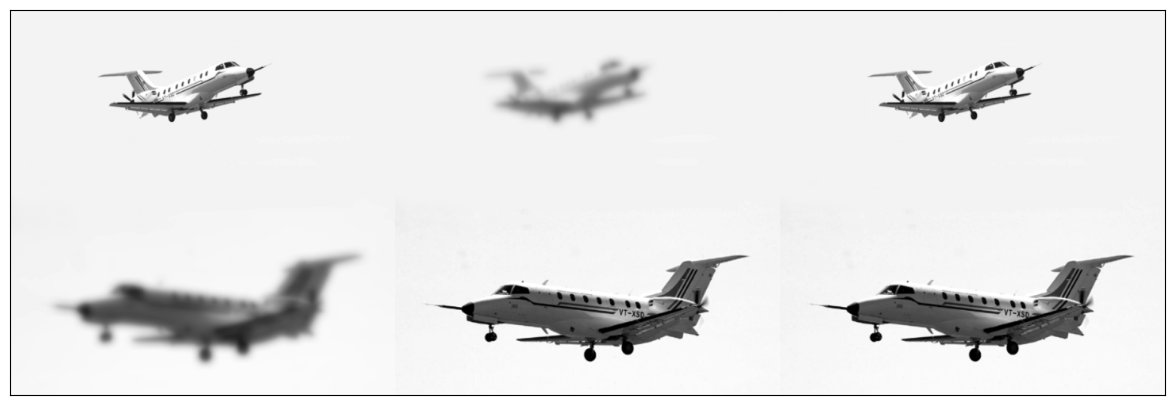

In [201]:
images = select_images()
image_1= images[0]
image_2= images[1]
plt.figure(figsize=(15,5))
plt.imshow(cv2.hconcat([image_1,image_2]),cmap='gray')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)   
if len(images)>2:
   reference_img = images[2]
   plt.imshow(cv2.hconcat([image_1,image_2,reference_img]),cmap='gray') 
plt.show()   

In [273]:
coeffs,out =fusion(image_1,image_2,level=2,details='max',approx='mean')

In [274]:
cv2.imshow('k',(out-reference_img)/255.)
cv2.waitKey(0)
cv2.destroyAllWindows()

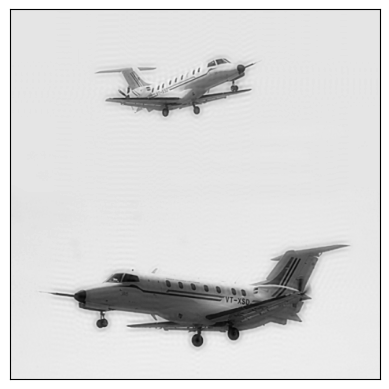

In [275]:
k=IMRDCT(coeffs)
plt.imshow(k,cmap='gray')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)  
plt.show()

In [276]:
# metrics 
def PFE(I_r, I_f):
    norm_diff = np.linalg.norm(I_r - I_f)
    norm_I_r = np.linalg.norm(I_r)
    pfe = (norm_diff / norm_I_r) * 100
    return pfe
def PSNR(I_r, I_f):
    mse = np.mean((I_r - I_f) ** 2)
    max_pixel = 255
    psnr = 10 * np.log10(max_pixel**2 /mse)
    return psnr
def SD(img):
    # Compute the histogram
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])

    # Compute the mean of the histogram
    mean = np.sum(hist * bins[:-1]) / np.sum(hist)

    # Compute the variance of the histogram
    variance = np.sum((bins[:-1] - mean) ** 2 * hist) / np.sum(hist)

    # Compute the standard deviation of the histogram
    return np.sqrt(variance)

In [280]:
info_no_ref = {'SD': SD(out)}
if len(images)>2:
    info_ref={'PFE': PFE(reference_img,out) , 'PSNR' :PSNR(reference_img,out),'SSIM': ssim(reference_img,out,data_range=255,full=False,use_sample_covariance=True)}
    info = {**info_ref,**info_no_ref}
else:
    info =info_no_ref 
print(info)   

{'PFE': 3.3230777575676522, 'PSNR': 30.367471265596713, 'SSIM': 0.9578027803379816, 'SD': 46.47642241307304}


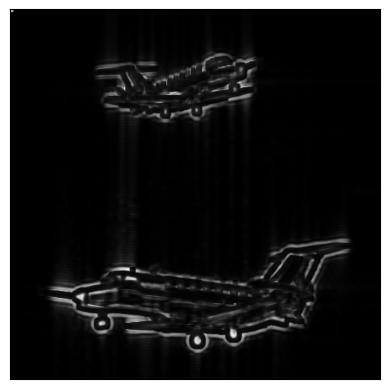

0.9578027803379816

In [279]:
score,diff = ssim(reference_img,out,full=True,data_range=255,use_sample_covariance=True)
plt.imshow(1-diff,cmap='gray')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)  
plt.show()
score

In [264]:
def getMSSISM(i1, i2):
    C1 = 14.75
    C2 = 39
    # INITS
    I1 = np.float32(i1) # cannot calculate on one byte large values
    I2 = np.float32(i2)
    I2_2 = I2 * I2 # I2^2
    I1_2 = I1 * I1 # I1^2
    I1_I2 = I1 * I2 # I1 * I2
    # END INITS
    # PRELIMINARY COMPUTING
    mu1 = cv2.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv2.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv2.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv2.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2                    # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2                    # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv2.divide(t3, t1)    # ssim_map =  t3./t1;
    mssim = cv2.mean(ssim_map)       # mssim = average of ssim map
    return mssim
# [get-mssim]


In [265]:
getMSSISM(reference_img,out)


(0.965892370474382, 0.0, 0.0, 0.0)

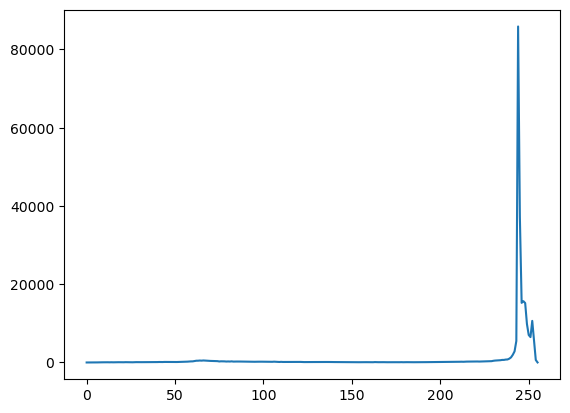

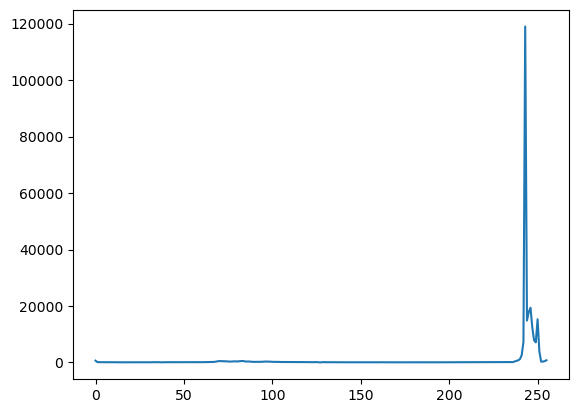

In [213]:
hist,bin = np.histogram(out.ravel(),256)
plt.plot(hist)
plt.show()
hist,bin = np.histogram(reference_img.ravel(),256)
plt.plot(hist)
plt.show()

In [ ]:
batches = []
for i in range(0, len(coeff_f), 4):
    batches.append(coeff_f[i:i+4])
def block_LL(LL_I,LH_I,HL_I,HH_I):
    LL = dct(LL_I, axis=1,type=2, norm='ortho')
    LH = dct(LH_I, axis=1,type=2, norm='ortho')
    HL = dct(HL_I, axis=1,type=2, norm='ortho')
    HH = dct(HH_I, axis=1,type=2, norm='ortho')
    block_up_col = idct(np.block([LL ,LH]),axis=1,type=2, norm='ortho')
    block_low_col = idct(np.block([HL ,HH]), axis=1,type=2, norm='ortho')
    block_up_row = dct(block_up_col,axis=0,type=2, norm='ortho')
    block_low_col = dct(block_low_col, axis=0,type=2, norm='ortho')
    block1=idct(np.block([[block_up_row],[block_low_col]]), axis=0,type=2, norm='ortho')
    return block1
i = block_LL(batches[0][0],batches[0][1],batches[0][2],batches[0][3])

In [ ]:
def dct_fusion(img1, img2):
    # convert images to grayscale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # divide images into non-overlapping blocks of size 8x8
    block_size = 500
    blocks1 = np.split(img1, img1.shape[0]//block_size, axis=0)
    blocks1 = [np.split(block, img1.shape[1]//block_size, axis=1) for block in blocks1]
    blocks2 = np.split(img2, img2.shape[0]//block_size, axis=0)
    blocks2 = [np.split(block, img2.shape[1]//block_size, axis=1) for block in blocks2]
    
    # apply DCT to each block
    dct1 = np.zeros_like(img1, dtype=np.float32)
    dct2 = np.zeros_like(img2, dtype=np.float32)
    for i in range(len(blocks1)):
        for j in range(len(blocks1[0])):
            dct1[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = cv2.dct(blocks1[i][j].astype(np.float32))
            dct2[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = cv2.dct(blocks2[i][j].astype(np.float32))
    
    # fuse DCT coefficients at each level
    fused_dct = np.zeros_like(dct1)
    coeffs1 = np.abs(dct1) >= np.abs(dct2)
    coeffs2 = np.abs(dct2) > np.abs(dct1)
    fused_dct[coeffs1] = dct1[coeffs1]
    fused_dct[coeffs2] = dct2[coeffs2]
    dct1 = cv2.idct(fused_dct).astype(np.float32)
    dct2 = cv2.idct(fused_dct).astype(np.float32)
    
    # reconstruct fused image from inverse DCT
    fused_img = np.zeros_like(img1)
    for i in range(len(blocks1)):
        for j in range(len(blocks1[0])):
            fused_img[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = cv2.idct(fused_dct[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]).astype(np.uint8)
    
    return fused_img


In [ ]:
levels = 2
fused_img = dct_fusion(images[0], images[1])